<a href="https://colab.research.google.com/github/annabelfast/BlackJack-Simulator/blob/master/NLP_nono.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

# Partie 1 : On se concentre sur les tweets

# TODO LIST:
- clustering avec les summary
-

In [5]:
# on commence par télécharger le modèle francophone
!python -m spacy download fr_core_news_lg
# Téléchargement du modèle anglophone
!python -m spacy download en_core_web_lg
# Pour la réduction de dimension
!pip install umap-learn
# Pour le clusturing
!pip install hdbscan


  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_lg-3.7.0/fr_core_news_lg-3.7.0-py3-none-any.whl (571.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl (587.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Parsing des données
Ici, on va transformer le fichier JSONL sous le format d'un dataframe plus simplement manipulable.

In [6]:
import csv

def read_csv(path: str) -> list[dict]:
    """
    Load a CSV file into a list of dictionaries.

    Args:
        path (str): The file path to the CSV file.

    Returns:
        list[dict]: A list of dictionaries containing the data read from the CSV file.

    Raises:
        FileNotFoundError: If the file does not exist.
        Exception: If there is an error reading the CSV file.
    """
    csv_data = []
    try:
        with open(path, mode='r', encoding='utf-8') as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                csv_data.append(row)
    except FileNotFoundError:
        print(f"File not found: {path}")
        raise
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        raise
    return csv_data

csv_data = read_csv("/content/dataset_only_english.csv")


In [7]:
import pandas as pd
from datetime import datetime
import re

def remove_extra_spaces(text: str) -> str:
    """
    Supprime les espaces superflus d'un texte (espaces multiples, début et fin).

    Args:
        text (str): Texte à nettoyer.

    Returns:
        str: Texte nettoyé.
    """
    if pd.isna(text):
        return ""
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

def process_tweet(tweets_data: list[dict]) -> pd.DataFrame:
    """
    Parse a batch of tweets.

    Args:
        tweets_data (list): List of dictionaries containing tweet data.

    Returns:
        pd.DataFrame: A pandas DataFrame containing parsed tweet data.
    """
    all_records = []

    for tweet in tweets_data:
        note_id = tweet.get("noteId", "")
        author_id = tweet.get("noteAuthorParticipantId", "")
        created_at = int(tweet.get("createdAtMillis", 0)) // 1000
        creation_date = datetime.utcfromtimestamp(created_at).strftime('%Y-%m-%d %H:%M:%S') if created_at > 0 else None
        tweet_id = tweet.get("tweetId", "")
        classification = tweet.get("classification", "")
        trustworthy_sources = tweet.get("trustworthySources", 0)
        summary = remove_extra_spaces(tweet.get("summary", ""))
        is_media_note = tweet.get("isMediaNote", 0)
        url = tweet.get("url", "")
        author_name = remove_extra_spaces(tweet.get("author_name", ""))
        screenname = tweet.get("screenname", "")
        text = remove_extra_spaces(tweet.get("text", ""))
        locked_status = tweet.get("lockedStatus", "")
        language_summary = tweet.get("language_summary", "")
        language_text = tweet.get("language_text", "")

        # Extraire les flags en colonnes individuelles
        misleading_flags = {col: tweet.get(col, 0) for col in tweet.keys() if col.startswith("misleading")}
        not_misleading_flags = {col: tweet.get(col, 0) for col in tweet.keys() if col.startswith("notMisleading")}

        record_data = (
            note_id, author_id, creation_date, tweet_id, classification,
            trustworthy_sources, summary, is_media_note, url, author_name, screenname,
            text, locked_status, language_summary, language_text,
            *misleading_flags.values(), *not_misleading_flags.values()
        )

        all_records.append(record_data)

    # Définir les colonnes
    columns = [
        "noteId", "noteAuthorParticipantId", "creation_date", "tweetId", "classification",
        "trustworthySources", "summary", "isMediaNote", "url", "author_name", "screenname",
        "text", "lockedStatus", "language_summary", "language_text"
    ]

    # Ajouter dynamiquement les colonnes pour les flags
    flag_columns = sorted({col for tweet in tweets_data for col in tweet.keys() if col.startswith("misleading") or col.startswith("notMisleading")})
    columns.extend(flag_columns)

    # Créer le DataFrame
    df = pd.DataFrame.from_records(all_records, columns=columns)

    return df

df = process_tweet(csv_data)
display(df.head())


,noteId,noteAuthorParticipantId,creation_date,tweetId,classification,trustworthySources,summary,isMediaNote,url,author_name,...,misleadingMissingImportantContext,misleadingOther,misleadingOutdatedInformation,misleadingSatire,misleadingUnverifiedClaimAsFact,notMisleadingClearlySatire,notMisleadingFactuallyCorrect,notMisleadingOther,notMisleadingOutdatedButNotWhenWritten,notMisleadingPersonalOpinion
0,1537147343715282945,5684B38EB58FD8BE75ABA37F0BE040EC70380B002ADF9D...,2022-06-15 18:57:40,1537080831751102467,MISINFORMED_OR_POTENTIALLY_MISLEADING,1,Teslas purchased after 12/31/19 are not eligib...,0,https://twitter.com/elonmusk/status/1537080831...,Elon Musk,...,0,0,1,0,0,0,0,0,0,0
1,1817361605237313557,CAA3DEA7CFC07BD080F8BEFA3E6BC1575E6DE1BE2D3BBD...,2024-07-28 00:49:06,1817211899894780374,MISINFORMED_OR_POTENTIALLY_MISLEADING,1,There is no evidence that Ronald Reagan said t...,0,https://twitter.com/Ikennect/status/1817211899...,I am Ken,...,0,0,0,1,1,0,0,0,0,0
2,1594777261995171846,DEB44EE644DD2F0AB97021D46CD7ABE322BF0199CDC38B...,2022-11-21 19:38:23,1594429003569438721,MISINFORMED_OR_POTENTIALLY_MISLEADING,1,SuperFollow subscription pricing can not be ch...,0,https://twitter.com/SaeedDiCaprio/status/15944...,Hurt CoPain,...,1,0,0,1,1,0,0,0,0,0
3,1777467809221746749,4BB4813625461AE3B657AA76389AD6F9C6A9EE05B0C183...,2024-04-08 22:45:24,1777424465892450725,MISINFORMED_OR_POTENTIALLY_MISLEADING,1,This photo both not real and not from the Apri...,0,https://twitter.com/rayasatrung/status/1777424...,Jasim Chatha,...,1,0,1,1,0,0,0,0,0,0
4,1523976585040257028,9B7C8A3AD7A906663202E031B29AEC915EB115C4F39463...,2022-05-10 10:41:46,1523430921659027456,MISINFORMED_OR_POTENTIALLY_MISLEADING,1,There is no reporting supporting this assertio...,0,https://twitter.com/TraveloreReport/status/152...,Travelore Report,...,0,0,0,1,0,0,0,0,0,0


# Importation des données

On importe la base de donnée avec l'ensemble des tweets que l'on va traiter.

In [8]:
# Importation de la librairie panda
import pandas as pd

# Importation du dataset
dataset = pd.read_csv("//content/dataset_only_english.csv")
# Éviter la troncature des colonnes
pd.set_option('display.max_colwidth', None)  # Affiche tout le contenu des cellules sans les tronquer
# Afficher un échantillon de 10 tweets (text) et de résumés (summary)
print("Exemples de tweets :")
print(dataset['text'].sample(10, random_state=42))

print("\nExemples de Community Notes :")
print(dataset['summary'].sample(10, random_state=42))

Exemples de tweets :
32122                                                                                                                                       🚨🚨🚨 WE ARE ABOUT TO SEE A MASSIVE BREAKOUT ⚠️ ALL BY DESIGN ⚠️ SHARE THIS VIDEO QUICKLY BEFORE THEY TAKE IT DOWN: https://t.co/XmhmZWoQf6— Matt Wallace (@MattWallace888) September 8, 2024\n
1072                                                                                    Keir Starmer was head of DPP between 2008 and 2013.He allowed the prosecution of Sub Postmasters during the Horizon scandal.He needs grilling over it.All credit to PeterExPat for pointing this out.— Goosey (@Goosey30111568) January 6, 2024\n
6757     Bernie Sanders and Pete Buttigieg are rallying Democrats to ABOLISH the unfair Electoral College.A Republican hasn't won the popular vote in nearly 20 YEARS, but the Electoral College is RIGGED in their favor…If 2/3 of states want to abolish the Electoral College, it’s GONE.— Scott 🇺🇸🌊💙 (@smaloney924) August 

<ipython-input-8-55af9d6c2769>:5: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("//content/dataset_only_english.csv")


#Nettoyage des 'text' et 'summary'


nettoyage de dates, url, emoji, les num qu'il y avait au début, les noms avec @

TO DO LIST :
* Regrouper les entités identiques : Remplacement des entités similaires (ex: "Donald Trump" devient "Trump")

In [9]:
import pandas as pd
import re
from tabulate import tabulate
from IPython.display import display, Markdown


# Fonction pour supprimer les emojis avec regex
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symboles & pictogrammes
        "\U0001F680-\U0001F6FF"  # Transport & cartes
        "\U0001F700-\U0001F77F"  # Alchimie
        "\U0001F780-\U0001F7FF"  # Géométrie supplémentaire
        "\U0001F800-\U0001F8FF"  # Suppléments divers
        "\U0001F900-\U0001F9FF"  # Suppléments supplémentaires
        "\U0001FA00-\U0001FA6F"  # Objets divers
        "\U0001FA70-\U0001FAFF"  # Objets supplémentaires
        "\U00002702-\U000027B0"  # Divers symboles
        "\U000024C2-\U0001F251"  # Symboles Enclosed
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    # Supprime les URLsm
    text = re.sub(r'https?://\S+', '', text)
    # Supprime les dates
    text = re.sub(r'\b(January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2}, \d{4}\b', '', text)
    # Supprimer les numéros au début
    text = re.sub(r'^\d+\s*', '', text)

    # Supprimer les emojis
    text = remove_emojis(text)

    # Supprimer tout après "—"
    text = re.sub(r'—.*$', '', text)
    return text.strip()

dataset['text'] = dataset['text'].apply(lambda x: clean_text(x))
dataset['summary'] = dataset['summary'].apply(lambda x: clean_text(x))

# Voir dataset en beau dataframe
df.head()

#Pour mieux voir les texts et summary
pd.set_option('display.max_colwidth', None)
print("Exemples de tweets :")
print(dataset['text'].sample(10, random_state=42))

print("\nExemples de Community Notes :")
print(dataset['summary'].sample(10, random_state=42))

Exemples de tweets :
32122                                                                                                                                              WE ARE ABOUT TO SEE A MASSIVE BREAKOUT  ALL BY DESIGN  SHARE THIS VIDEO QUICKLY BEFORE THEY TAKE IT DOWN:  Matt Wallace (@MattWallace888)
1072                                                                                   Keir Starmer was head of DPP between 2008 and 2013.He allowed the prosecution of Sub Postmasters during the Horizon scandal.He needs grilling over it.All credit to PeterExPat for pointing this out.
6757     Bernie Sanders and Pete Buttigieg are rallying Democrats to ABOLISH the unfair Electoral College.A Republican hasn't won the popular vote in nearly 20 YEARS, but the Electoral College is RIGGED in their favor…If 2/3 of states want to abolish the Electoral College, it’s GONE.
32091                                                                                                                       

# Pipeline NLP - Spacy

[Spacy](https://spacy.io/) est une librairie NLP qui propose des modèles pré-entrainés en français, anglais, etc.

Le principe général consiste à envoyer un texte à Spacy, qui va appliquer différentes fonctions linguistiques et nous retourner un objet "Doc" annoté.

Parmi ces fonctions linguistiques les plus couramment utilisées sont

*   tokenization : consiste à découper le texte en "mots"
*   Part of Speech (PoS) tagging : consiste à identifier le type de mot (nom, verbe, adjectif...)
* lemmatization : transforme le mot dans sa forme canonique. Un nom sera remis au singulier, masculin. Un verbe, à l'infinitif.
* Name Entity Recognition (NER) : détecte une entité nommée, telle qu'une localisation, une personne, une organisation



['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']
Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'url', 'author_name', 'screenname', 'text',
       'lockedStatus', 'language_summary', 'language_text'],
      dtype='object')


NLP Process: 100%|██████████| 38705/38705 [02:50<00:00, 226.59it/s]


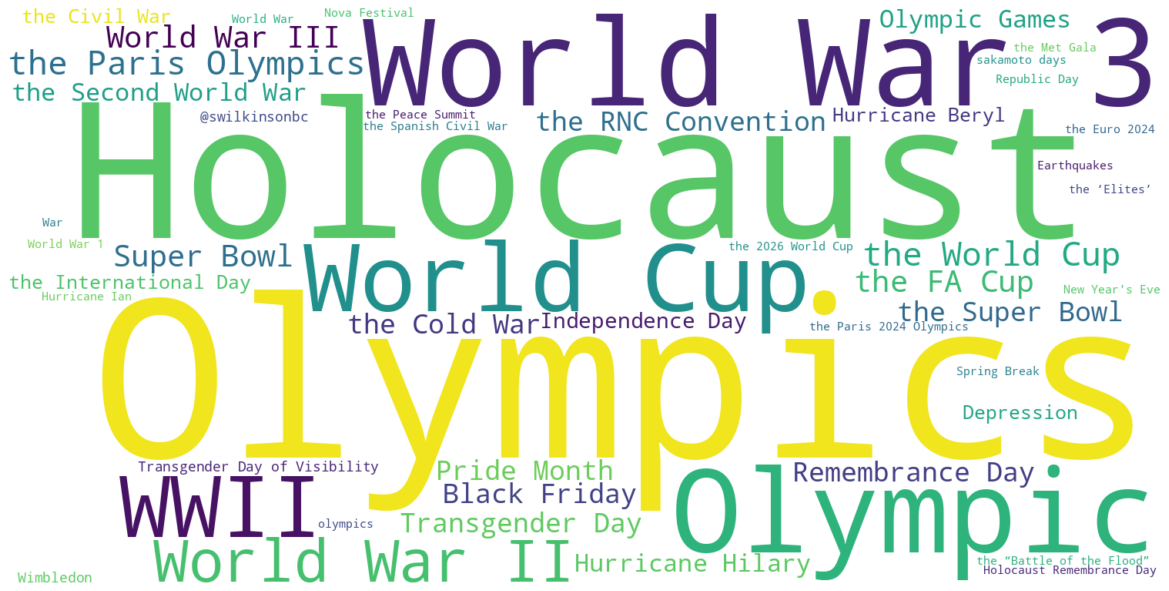

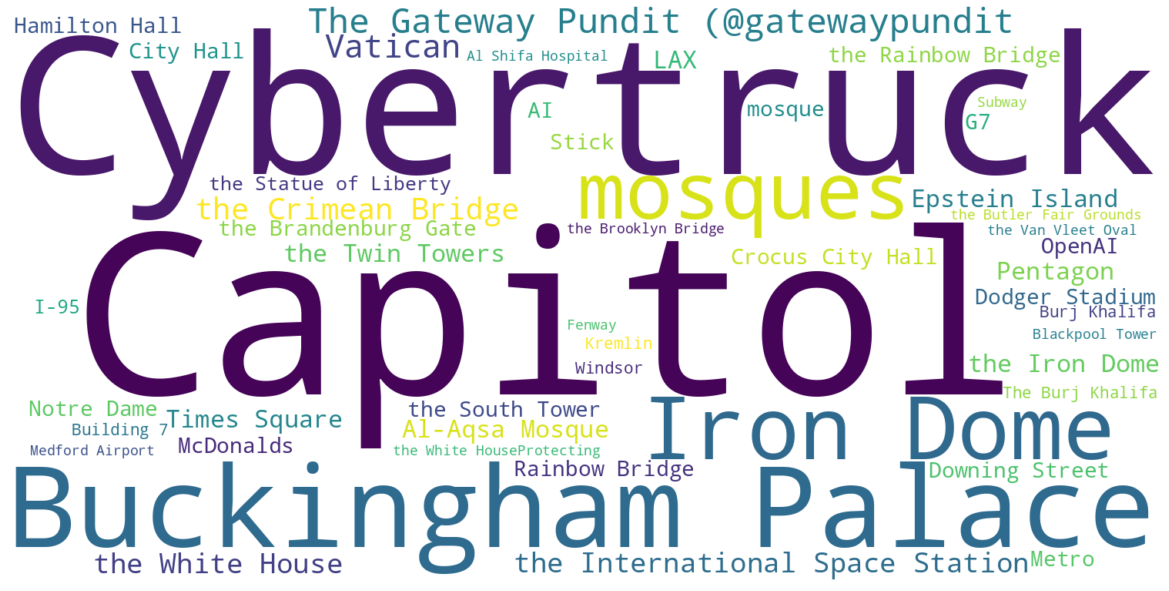

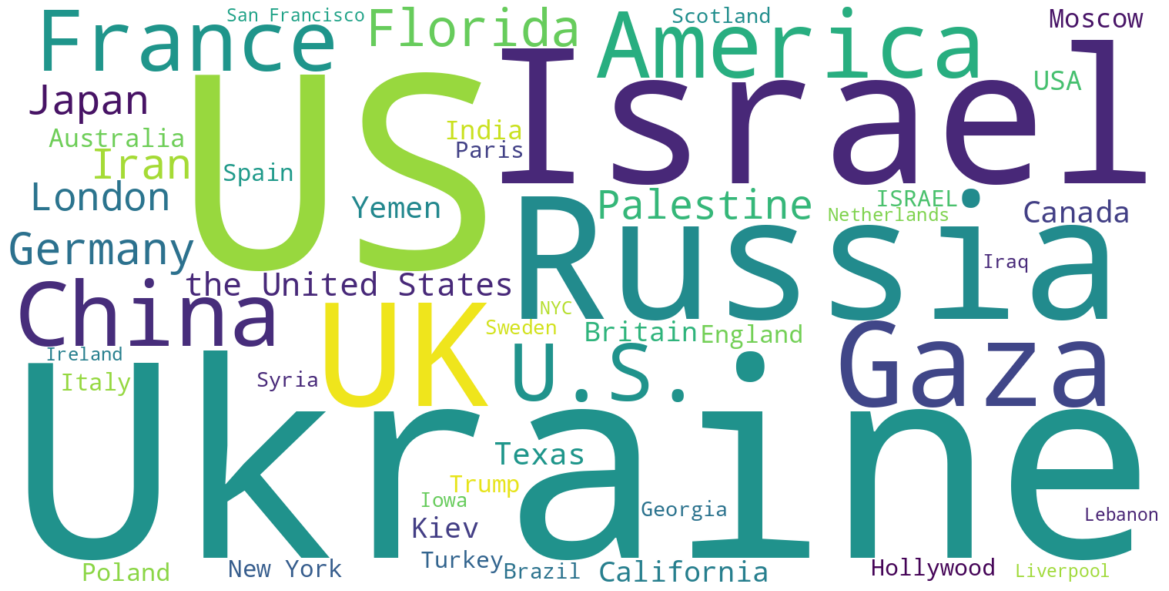

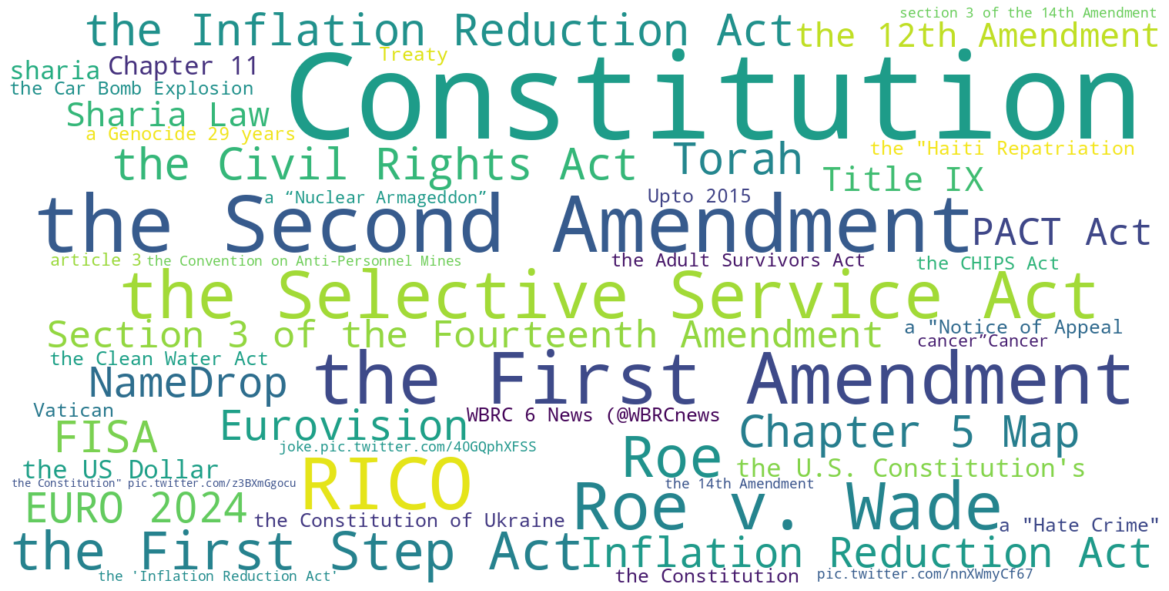

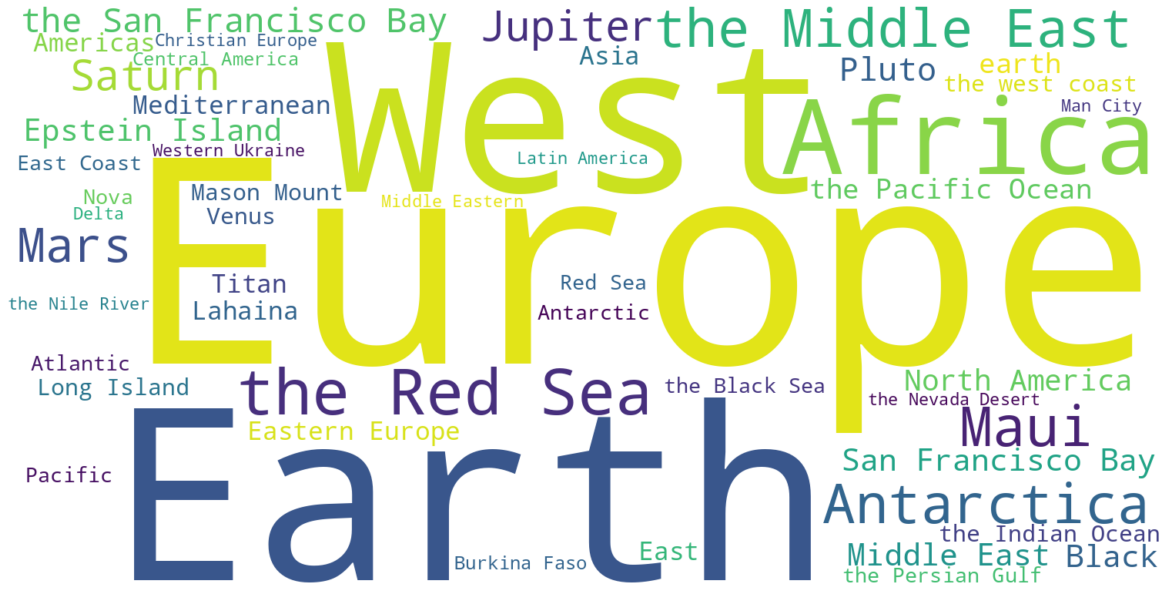

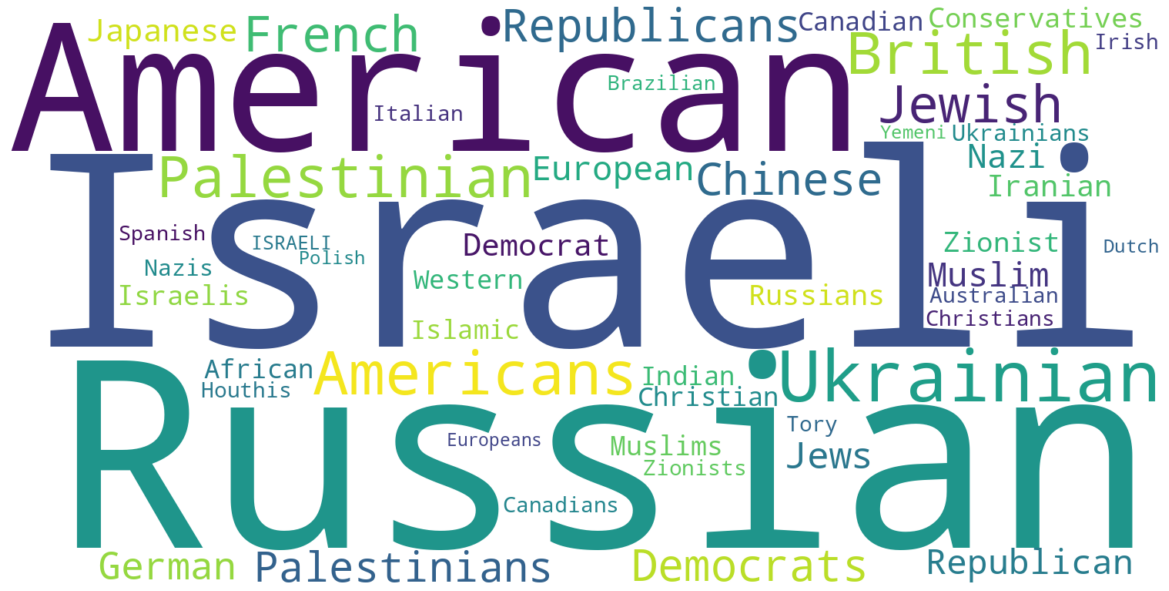

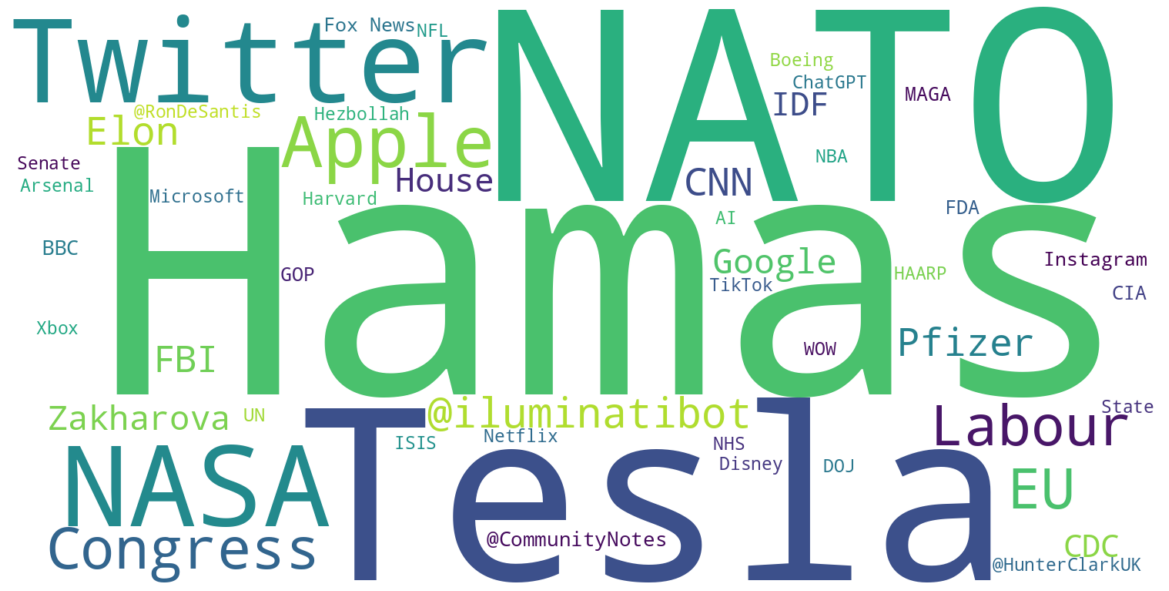

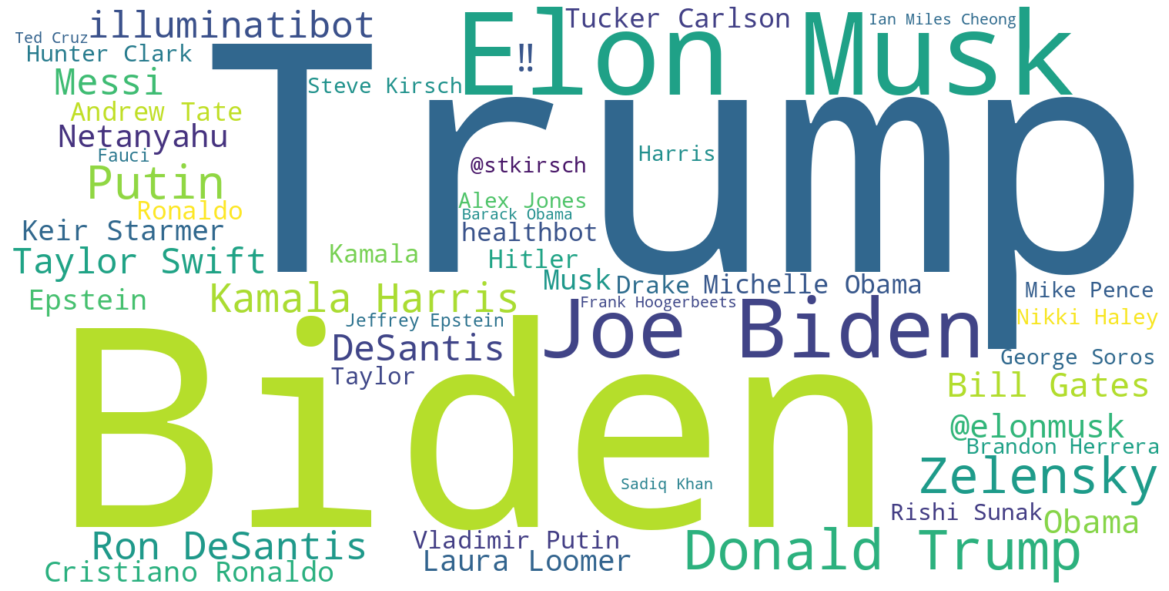

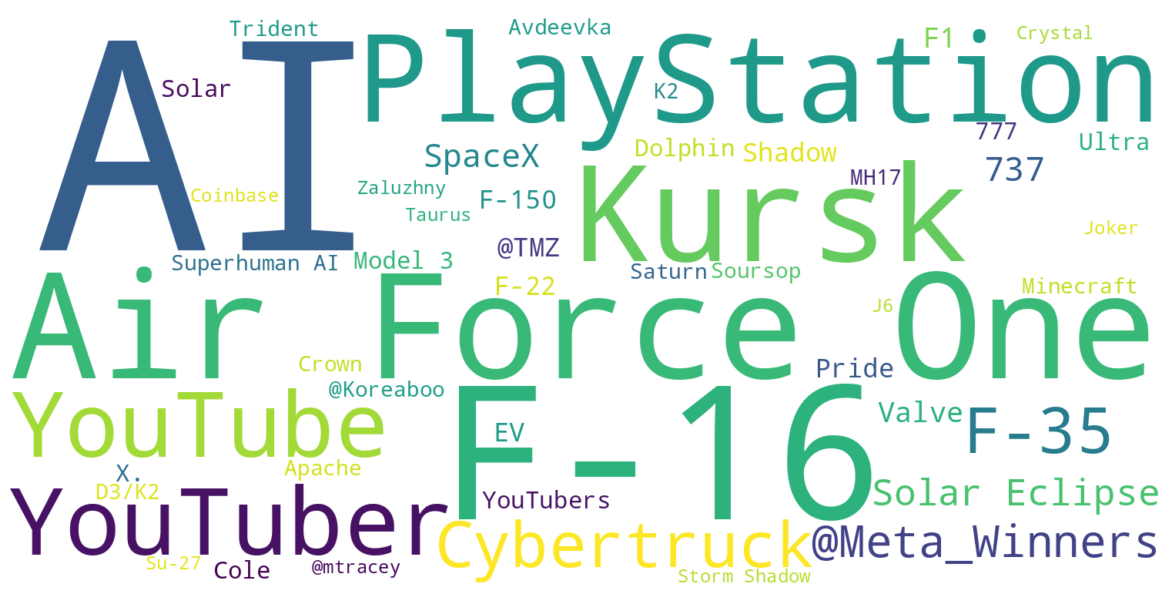

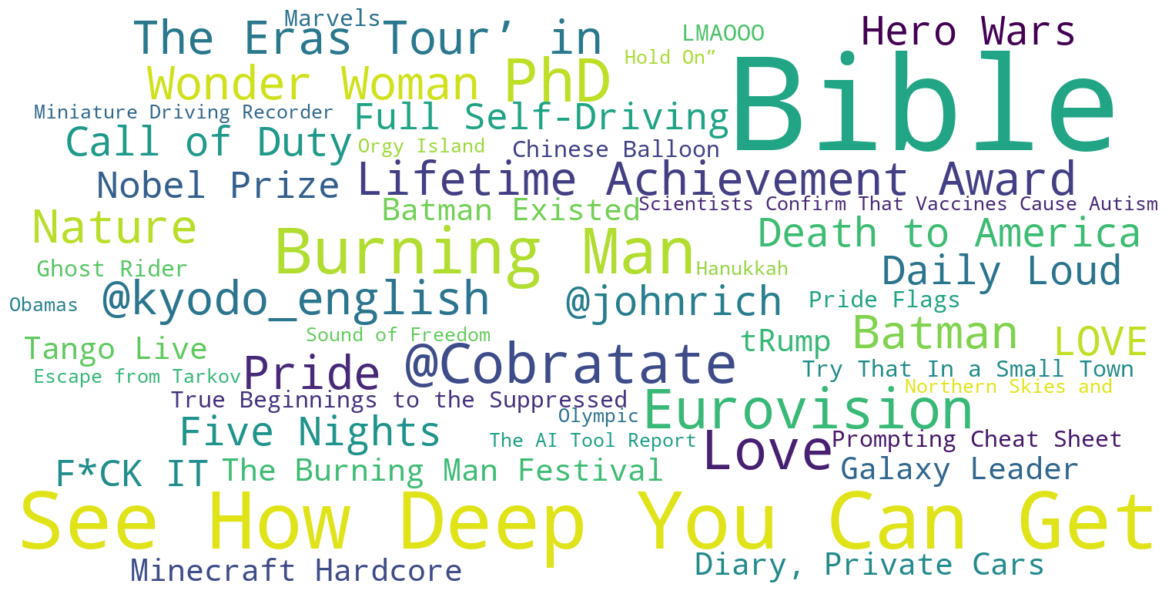





Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'url', 'author_name', 'screenname', 'text',
       'lockedStatus', 'language_summary', 'language_text', 'NER_type',
       'NER_text', 'NER_start_char', 'NER_end_char'],
      dtype='object')


In [10]:
import spacy
import torch
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm


# juju modif df =
df = dataset.copy()

# Ici on sélectionne le type d'entités nommées à détecter
entity_labels = ['EVENT', 'FAC', 'GPE', 'LAW', 'LOC', 'NORP', 'ORG', 'PERSON', 'PRODUCT', 'WORK_OF_ART']


def load_spacy_model(model: str) -> spacy.language.Language:
    """
    Load a spaCy model with optional configurations.

    Args:
        model: str
          Name of the spaCy model to load

    Returns:
        nlp: spacy.language.Language
          Loaded spaCy language processing pipeline
    """
    if torch.cuda.is_available():
        spacy.prefer_gpu()

    nlp = spacy.load(model)
    return nlp

def spacy_NER(nlp, df: pd.DataFrame, col_text: str, entities_to_keep=None, explode: bool = True, batch_size: int = 100, n_process: int = 1) -> pd.DataFrame:
    """
    Spacy implementation of NER.

    Args:
        nlp : spacy.language.Language
            The spaCy language processing pipeline.
        df : pd.DataFrame
            DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        entities_to_keep : list, optional
            List of entity types to keep. Default is ['PERSON','ORG', 'LOC'].
        batch_size : int, optional
            Batch sizes
        n_process : int, optional
            Number of processes
        pd.DataFrame
          DataFrame containing the NER information.
    """
    if entities_to_keep is None:
        entities_to_keep =['EVENT', 'FAC', 'GPE', 'LAW', 'LOC', 'NORP', 'ORG', 'PERSON', 'PRODUCT', 'WORK_OF_ART']

    l_text = df[col_text].dropna().tolist() # Éviter les NaN
    all_records = []

    for doc in tqdm(nlp.pipe(l_text, batch_size=batch_size, n_process=n_process), total=len(l_text), desc="NLP Process"):
        NER_type = []
        NER_text = []
        NER_start_char = []
        NER_end_char = []

        for ent in doc.ents:
            if ent.label_ in entities_to_keep:
                NER_type.append(ent.label_)
                NER_text.append(ent.text)
                NER_start_char.append(ent.start_char)
                NER_end_char.append(ent.end_char)

        record = (NER_type, NER_text, NER_start_char, NER_end_char)
        all_records.append(record)

    df['NER_type'], df['NER_text'], df['NER_start_char'], df['NER_end_char'] = zip(*all_records)
    return df

def generate_wordcloud(df: pd.DataFrame,
                       col_word: str,
                       col_metric: str,
                       width: int = 1500,
                       height: int = 750,
                       dpi: int = 72,
                       background_color: str = 'white',
                       show: bool = False) -> WordCloud:
    """
    Generate a word cloud from a DataFrame.

    Args:
      df (pd.DataFrame): DataFrame containing word frequency data.
      col_word (str): Column name containing words.
      col_metric (str): Column name containing frequency metrics for each word.
      width (int, optional): Width of the word cloud image. Defaults to 1500.
      height (int, optional): Height of the word cloud image. Defaults to 750.
      dpi (int, optional): Dots per inch for image resolution. Defaults to 72.
      background_color (str, optional): Background color of the word cloud image. Defaults to 'white'.
      show (bool, optional): Whether to display the word cloud image. Defaults to False.

    Returns:
      WordCloud: WordCloud object representing the generated word cloud.
    """
    top_n_words = {row[col_word]: row[col_metric] for _, row in df.iterrows()}

    wordcloud = WordCloud(width=width, height=height, background_color=background_color, prefer_horizontal=1).generate_from_frequencies(top_n_words)

    if show:
        plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    return wordcloud

# Chargement du modèle spaCy
nlp = load_spacy_model("en_core_web_lg")

# Vérification des labels du modèle NER
pipe_details = nlp.get_pipe("ner")
labels = list(pipe_details.labels)
print(labels)

# Vérifie que la colonne 'text' existe dans le DataFrame
print(df.columns)  # Vérifie les colonnes de ton DataFrame

# Si la colonne contenant le texte est bien 'text', tu continues ainsi :
df = spacy_NER(nlp, df, "text", entities_to_keep=entity_labels, batch_size=100, n_process=1)

# on crée un nouveau dataframe où 1 ligne = 1 entité
df_entities = df.copy()
df_entities = df_entities[df_entities['NER_type'].apply(lambda x: len(x) > 0)]
df_entities = df_entities.explode(['NER_type', 'NER_text'])

# on affiche les entités les plus fréquemment citées
for NER_type in entity_labels:
    df_top_entities = (
        df_entities[df_entities['NER_type'] == NER_type]
        .groupby(['NER_text', 'NER_type'])
        .agg({"tweetId": 'nunique', 'text': 'sum'})
        .sort_values(by="tweetId", ascending=False)
        .reset_index()
    )
    generate_wordcloud(df_top_entities.head(50), "NER_text", "tweetId", show=True)
    print('\n' * 3)

print(df.columns)

In [11]:
print(df.columns)

Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'url', 'author_name', 'screenname', 'text',
       'lockedStatus', 'language_summary', 'language_text', 'NER_type',
       'NER_text', 'NER_start_char', 'NER_end_char'],
      dtype='object')


test chat gpt pour enlever les doublons de person

In [ ]:
import spacy
import torch
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ici on sélectionne le type d'entités nommées à détecter
entity_labels = ['EVENT', 'FAC', 'GPE', 'LAW', 'LOC', 'NORP', 'ORG', 'PERSON', 'PRODUCT', 'WORK_OF_ART']

def load_spacy_model(model: str) -> spacy.language.Language:
    """
    Load a spaCy model with optional configurations.
    """
    if torch.cuda.is_available():
        spacy.prefer_gpu()
    return spacy.load(model)

def spacy_NER(nlp, df: pd.DataFrame, col_text: str, entities_to_keep=None, batch_size: int = 100, n_process: int = 1) -> pd.DataFrame:
    """
    Spacy implementation of NER.
    """
    if entities_to_keep is None:
        entities_to_keep = entity_labels

    l_text = df[col_text].dropna().tolist()  # Éviter les NaN
    all_records = []

    for doc in tqdm(nlp.pipe(l_text, batch_size=batch_size, n_process=n_process), total=len(l_text), desc="NLP Process"):
        NER_type, NER_text, NER_start_char, NER_end_char = [], [], [], []

        for ent in doc.ents:
            if ent.label_ in entities_to_keep:
                NER_type.append(ent.label_)
                NER_text.append(ent.lemma_ if ent.lemma_ else ent.text)  # Normalisation avec lemma
                NER_start_char.append(ent.start_char)
                NER_end_char.append(ent.end_char)

        all_records.append((NER_type, NER_text, NER_start_char, NER_end_char))

    df['NER_type'], df['NER_text'], df['NER_start_char'], df['NER_end_char'] = zip(*all_records)
    return df

def normalize_entities(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalise les entités similaires (ex: 'Trump' et 'Donald Trump') en utilisant la fréquence.
    """
    alias_map = {}
    for name, count in df['NER_text'].value_counts().items():
        if any(name in alias for alias in alias_map.values()):
            continue
        # Escape special characters in name for regex
        escaped_name = re.escape(name)
        similar = df[df['NER_text'].str.contains(rf'\b{escaped_name}\b', regex=True, na=False)]
        if len(similar) > 1:
            main_name = similar.iloc[0]['NER_text']  # Garde la plus fréquente
            for alt_name in similar['NER_text']:
                alias_map[alt_name] = main_name

    df['NER_text'] = df['NER_text'].replace(alias_map)
    return df

def generate_wordcloud(df: pd.DataFrame, col_word: str, col_metric: str, width: int = 1500, height: int = 750, dpi: int = 72, background_color: str = 'white', show: bool = False) -> WordCloud:
    """
    Generate a word cloud from a DataFrame.
    """
    top_n_words = {row[col_word]: row[col_metric] for _, row in df.iterrows()}
    wordcloud = WordCloud(width=width, height=height, background_color=background_color, prefer_horizontal=1).generate_from_frequencies(top_n_words)

    if show:
        plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    return wordcloud

# Chargement du modèle spaCy
nlp = load_spacy_model("en_core_web_lg")

# Vérification des labels du modèle NER
print(nlp.get_pipe("ner").labels)

# Assurez-vous que df contient bien la colonne 'text'
print(df.columns)

df = spacy_NER(nlp, df, "text", entities_to_keep=entity_labels, batch_size=100, n_process=1)

df_entities = df.copy()
df_entities = df_entities[df_entities['NER_type'].apply(lambda x: len(x) > 0)]
df_entities = df_entities.explode(['NER_type', 'NER_text'])

df_entities = normalize_entities(df_entities)  # Applique la normalisation

# Génération des wordclouds
for NER_type in entity_labels:
    df_top_entities = (
        df_entities[df_entities['NER_type'] == NER_type]
        .groupby(['NER_text', 'NER_type'])
        .agg({"tweetId": 'nunique', 'text': 'sum'})
        .sort_values(by="tweetId", ascending=False)
        .reset_index()
    )
    generate_wordcloud(df_top_entities.head(50), "NER_text", "tweetId", show=True)
    print('\n' * 3)

print(df.columns)


('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')
Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'url', 'author_name', 'screenname', 'text',
       'lockedStatus', 'language_summary', 'language_text', 'NER_type',
       'NER_text', 'NER_start_char', 'NER_end_char'],
      dtype='object')


NLP Process: 100%|██████████| 38705/38705 [02:43<00:00, 236.38it/s]


# Stats descriptives

*   Dans un but d'obtenir des labels intéressants pour le clustering, on récupère pour chaque type d'entity le top 10 des mots les plus fréquents
*   Ce sera réutilisé plus tard



In [ ]:
from collections import Counter

def get_top_entities(df_entities, entity_labels, top_n=10):
    """
    Retourne les 10 entités les plus fréquentes pour chaque type d'entité.

    Args:
        df_entities (pd.DataFrame): DataFrame contenant les entités reconnues.
        entity_labels (list): Liste des types d'entités à analyser.
        top_n (int): Nombre d'entités les plus fréquentes à retourner.

    Returns:
        dict: Un dictionnaire avec les types d'entités comme clés et les 10 entités les plus fréquentes comme valeurs.
    """
    top_entities = {}

    for entity in entity_labels:
        entity_counter = Counter(df_entities[df_entities['NER_type'] == entity]['NER_text'])
        top_entities[entity] = entity_counter.most_common(top_n)

    return top_entities

# Obtention des 10 entités les plus fréquentes par type
top_entities = get_top_entities(df_entities, entity_labels)

# Affichage des résultats
for entity, words in top_entities.items():
    print(f"Top {len(words)} entités pour {entity}:")
    for word, count in words:
        print(f"  {word}: {count}")
    print("\n" + "-"*50 + "\n")


# Lemmatisation


In [ ]:
import pandas as pd


def lemmatization(nlp,
                  df: pd.DataFrame,
                  col_text: str,
                  col_lemma: str,
                  pos_to_keep: list,
                  stopwords: list,
                  batch_size: int = 100,
                  n_process: int = 1,
                  join_list: bool = False) -> pd.DataFrame:
    """
    Perform natural language processing tasks using spaCy : tokenization, PoS Tagging and lemmatization

    Args:
        nlp : spacy.Language
            The spaCy language model.
        df : pandas.DataFrame
            The DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        col_lemma : str
            The name of the column to store the lemmatized text data.
        pos_to_keep : list
            A list of part-of-speech tags to keep during lemmatization.
        stopwords : list
            A list of stopwords to remove during processing.
        batch_size : int, optional
            The batch size for spaCy processing. Default is 100.
        n_process : int, optional
            The number of processes for parallel processing. Default is 1.
        join_list : bool, optional
            Whether to join the lemmas into a single string. Default is False.

    Returns:
        pandas.DataFrame
            The DataFrame with processed text data.

    """
    all_lemmas=[]
    tokens_counts=[]
    tokens_kept=[]

    text=list(df[col_text].astype('unicode').values)

    for doc in tqdm(nlp.pipe(text, batch_size=batch_size, n_process=n_process), total= len(text), desc = "NLP Process"):

# garde uniquement les mots pertinents, flitre
        if len(pos_to_keep)>0 and len(stopwords)>0:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep)>0 and len(stopwords) < 1:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep) < 1 and len(stopwords) > 0:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords]
        else :
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space)]

        all_lemmas.append(lemmas_list)

    if join_list:
        df[col_lemma]=[' '.join(map(str, l)) for l in all_lemmas]
    else:
        df[col_lemma]=all_lemmas

    return df

# toujours à l'aide de notre modèle spacy, on lemmatise le texte en ne conservant que certains PoS tags

df = lemmatization(nlp, df, "text", "lemmatized_text", pos_to_keep=["VERB","NOUN","ADJ", "ADV", "PROPN"], stopwords = [], batch_size = 100, n_process = 1, join_list = True)
print(df["lemmatized_text"])

In [ ]:
print(df.columns)

# Comptage des occurences


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def count_words(lst_text : list, stop_words : list = []) -> pd.DataFrame:
  vectorizer = CountVectorizer(stop_words=stop_words)

  # Transformation des textes en matrice de compte
  X = vectorizer.fit_transform(lst_text)

  # Extraction des mots et de leurs fréquences
  word_freq = pd.DataFrame({
      'word': vectorizer.get_feature_names_out(),
      'frequency': X.toarray().sum(axis=0)
  })

  # Tri par fréquence décroissante
  word_freq = word_freq.sort_values(by='frequency', ascending=False)
  return word_freq

def generate_wordcloud(df, word_col, freq_col, show=True):
    word_freq_dict = dict(zip(df[word_col], df[freq_col]))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

    if show:
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

# on filtre certains termes / erreurs du modèle qui auraient pu faire partie d'une procédure de nettoyage en amont
stop_words = ['https','pic','twitter','com','@', 'have', 'just', 'people', 'year', 'now', 'say', 'get', 'go', 'do', 'new', 'make', 'more', 'so', 'see', 'breaking','time',
              'know', 'take', 'use', 'day', 'first', 'man', 'world', 'today', 'us', 'come', 'only', 'want', 'look', 'never', 'good', 'be', 'away', 'find', 'old', 'try',
              'name', 'one', 'even', 'work', 'other', 'call', 'show','tell', 'need', 'high', 'here', 'here', 'put', 'play', 'big', 'thing', 'well', 'month', 'same',
              'think', 'also', 'ever', 'leave', 'send','january','february','march','april','may','june','july','august','september','october','november','december','co']

# on affiche les termes les plus fréquents
word_frequencies = count_words(df['lemmatized_text'].to_list(), stop_words)
display(word_frequencies.head())
generate_wordcloud(word_frequencies.head(100), "word", "frequency", show = True)

# Sampling
On peut entrainer notre modèle sur l'ensemble des données. Néanmoins, le plus souvent, on dispose d'un dataset volumineux. Dès lors, on défini une méthode d'échantillonage. On entraine le modèle sur cet échantillon, puis on execute l'inférence sur le reste du dataset.

Si on dispose d'un GPU, on peut utiliser [Rapids](https://rapids.ai/) qui intègre une implémentation de pandas / sklearn pour réaliser les traitements plus rapidement et/ou sur de plus gros volumes de données.

In [ ]:
df['text']

# Echantillon :

*   On a pris un échantillon de 10 000 tweets, soit X % du jeu de données de départ
*   On fixe la graine (todo)



In [ ]:
df_sample = df.sample(10000) # fait un échantillon
df_sample.shape # renvoie (nombre de lignes, nombre de colonnes)

In [ ]:
df_not_sample =  df[~df['tweetId'].isin(df_sample['tweetId'])] # renvoie le complément du dataset qui est dans sample
df_not_sample.shape # renvoie (nombre de lignes, nombre de colonnes)

# Topic Modeling - Etape n°1 - Vectorisation

On va transformer nos textes en vecteurs ("embeddings") à l'aide d'un modèle pré-entrainé de type "SentenceTransformer".

Le choix du modèle dépendra du type de données

# TO DO :

*   Améliorer la rapidité de ce code



In [ ]:
from sentence_transformers import SentenceTransformer

# on charge notre modèle
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# on encode nos textes
sample_embeddings = model.encode(list(df_sample['text']))
not_sample_embeddings = model.encode(list(df_not_sample['text']),show_progress_bar=True)

# Taille de nos vecteurs : nb de textes x nb de dimensions du vecteur
sample_embeddings.shape

# Etape n°2 - Réduction de dimensions

Chaque texte est désormais représenté par un vecteur en 384 dimensions. On va effectuer une réduction de dimensions pour

*   facilement représenter le résultat en 2 ou 3 dimensions
*   limiter les calculs
* s'intéresser aux dimensions les plus "significatives"

Il existe différentes méthodes statistiques : LSA, LDA, TSNE, [UMAP](https://umap-learn.readthedocs.io/en/latest/api.html)...

# TO-DO :

*   On a utilisé UMAP ici, est-ce qu'on regarde autrement ?


In [ ]:
import umap
import plotly.express as px

parameters = {"n_neighbors" : 10,
              "n_components" : 2,
              "min_dist" : 0.1,
              "metric" : "cosine",
              "spread" : 0.8,
              "random_state" : 42,
              "n_epochs" : 1000,
              "learning_rate" : 0.01
              }


reducer = umap.UMAP(**parameters).fit(sample_embeddings)

#on récupère les vecteurs réduits
sample_reduced_embeddings = reducer.transform(sample_embeddings)

# Taille de notre vecteur réduit
sample_reduced_embeddings.shape

# on ajoute les coordonnées réduites du vecteur dans notre dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]

# on affiche nos résultats
fig = px.scatter(
    df_sample,
    x="x",
    y="y",
    width = 1000,
    height = 1000
)
fig.show()

In [ ]:
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings)

df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

df_concat = pd.concat([df_sample, df_not_sample])

# on affiche nos résultats
fig = px.scatter(
    df_concat,
    x="x",
    y="y",
    width = 1000,
    height = 1000
)
fig.show()

# Supervisation

On a réalisé une réduction de dimensions non supervisée, il est possible de fournir des exemples à UMAP pour "orienter" ses résultats

# Supervisation : occurences pour choisir les labels

récuperer les entités dans des listes pour simplifier

# Supervisation : test 1 Superviser avec les personnalités connues

On a réalisé une réduction de dimensions non supervisée, il est possible de fournir des exemples à UMAP pour "orienter" ses résultats

In [ ]:
keywords_of_interest = ['Trump', 'Biden', 'Elon Musk', 'Joe Biden', 'Donald Trump', 'Zelensky', 'Putin', 'Kamala Harris', 'Ron DeSantis']


df_sample['label'] = df['NER_text'].apply(lambda x: next((kw for kw in x if kw in keywords_of_interest), None))

df_sample['label'] = df_sample['label'].map({
    "Trump" : 1,
    "Biden" : 2,
    "Elon Musk" : 3,
    "Joe Biden" : 4,
    "Donald Trump" : 5,
    "Zelensky" : 6,
    "Putin" : 7,
    "Kamala Harris" : 8,
    "Ron DeSantis" : 9,
})

df_sample['label'] = df_sample['label'].fillna(-1)

supervised_reducer = umap.UMAP(**parameters).fit(X = sample_embeddings, y = df_sample['label'], convert_dtype = True)


#on récupère les vecteurs réduits
supervised_sample_reduced_embeddings = supervised_reducer.transform(sample_embeddings)

# Taille de notre vecteur réduit
supervised_sample_reduced_embeddings.shape

# on ajoute les coordonnées réduites du vecteur dans notre dataframe
df_sample['x_supervised'] = supervised_sample_reduced_embeddings[:,0]
df_sample['y_supervised'] = supervised_sample_reduced_embeddings[:,1]

df_sample['label'] = df_sample['label'].astype(str)
# on affiche nos résultats
fig = px.scatter(
    df_sample,
    x="x_supervised",
    y="y_supervised",
    color="label",
    width = 1000,
    height = 1000
)
fig.show()

In [ ]:
print(df.columns)

In [ ]:
df_sample[['text', 'label']]

# Supervisation : test 2 Superviser avec GPE entity

On a réalisé une réduction de dimensions non supervisée, il est possible de fournir des exemples à UMAP pour "orienter" ses résultats

In [ ]:
keywords_of_interest = ['Ukraine', 'US', 'Israel', 'Russia', 'UK', 'Gaza', 'America', 'China', 'France', 'U.S.']


df_sample['label'] = df['NER_text'].apply(lambda x: next((kw for kw in x if kw in keywords_of_interest), None))

df_sample['label'] = df_sample['label'].map({
    "Ukraine" : 1,
    "US" : 2,
    "Israel" : 3,
    "Russia" : 4,
    "UK" : 5,
    "Gaza" : 6,
    "America" : 7,
    "China" : 8,
    "France" : 9,
})

df_sample['label'] = df_sample['label'].fillna(-1)

supervised_reducer = umap.UMAP(**parameters).fit(X = sample_embeddings, y = df_sample['label'], convert_dtype = True)


#on récupère les vecteurs réduits
supervised_sample_reduced_embeddings = supervised_reducer.transform(sample_embeddings)

# Taille de notre vecteur réduit
supervised_sample_reduced_embeddings.shape

# on ajoute les coordonnées réduites du vecteur dans notre dataframe
df_sample['x_supervised'] = supervised_sample_reduced_embeddings[:,0]
df_sample['y_supervised'] = supervised_sample_reduced_embeddings[:,1]

df_sample['label'] = df_sample['label'].astype(str)
# on affiche nos résultats
fig = px.scatter(
    df_sample,
    x="x_supervised",
    y="y_supervised",
    color="label",
    width = 1000,
    height = 1000
)
fig.show()

# Supervisation : test 3 Superviser avec ORG entity

On a réalisé une réduction de dimensions non supervisée, il est possible de fournir des exemples à UMAP pour "orienter" ses résultats


In [ ]:
keywords_of_interest = ['Hamas', 'NATO', 'Tesla', 'Twitter', 'NASA', 'Apple', 'Congress', 'EU', 'Labour', '@iluminatibot']


df_sample['label'] = df['NER_text'].apply(lambda x: next((kw for kw in x if kw in keywords_of_interest), None))

df_sample['label'] = df_sample['label'].map({
    "Hamas" : 1,
    "NATO" : 2,
    "Tesla" : 3,
    "Twitter" : 4,
    "NASA" : 5,
    "Apple" : 6,
    "Congress" :7,
    "EU" : 8,
    "Labour" : 9,
    "@iluminatibot" : 10
})

df_sample['label'] = df_sample['label'].fillna(-1)

supervised_reducer = umap.UMAP(**parameters).fit(X = sample_embeddings, y = df_sample['label'], convert_dtype = True)


#on récupère les vecteurs réduits
supervised_sample_reduced_embeddings = supervised_reducer.transform(sample_embeddings)

# Taille de notre vecteur réduit
supervised_sample_reduced_embeddings.shape

# on ajoute les coordonnées réduites du vecteur dans notre dataframe
df_sample['x_supervised'] = supervised_sample_reduced_embeddings[:,0]
df_sample['y_supervised'] = supervised_sample_reduced_embeddings[:,1]

df_sample['label'] = df_sample['label'].astype(str)
# on affiche nos résultats
fig = px.scatter(
    df_sample,
    x="x_supervised",
    y="y_supervised",
    color="label",
    width = 1000,
    height = 1000
)
fig.show()

# Superviser avec les trois

In [ ]:
keywords_of_interest = ['Hamas', 'NATO', 'Tesla', 'Twitter', 'NASA', 'Apple', 'Congress', 'EU', 'Labour', '@iluminatibot','Ukraine', 'US',
                        'Israel', 'Russia', 'UK', 'Gaza', 'America', 'China', 'France', 'U.S.','Trump', 'Biden', 'Elon Musk', 'Joe Biden',
                        'Donald Trump', 'Zelensky', 'Putin', 'Kamala Harris', 'Ron DeSantis']


df_sample['label'] = df['NER_text'].apply(lambda x: next((kw for kw in x if kw in keywords_of_interest), None))

df_sample['label'] = df_sample['label'].map({
    "Hamas" : 1,
    "NATO" : 2,
    "Tesla" : 3,
    "Twitter" :4,
    "NASA" : 5,
    "Apple" : 6,
    "Congress" :7,
    "EU" : 8,
    "Labour" : 9,
    "@iluminatibot" :10,
    "Ukraine" : 11,
    "US" :12,
    "Israel" : 13,
    "Russia" : 14,
    "UK":15,
    "Gaza":16,
    "America":17,
    "China":18,
    "France":19,
    "U.S.":20,
    "Trump" : 21,
    "Biden" : 22,
    "Elon Musk" : 23,
    "Joe Biden" : 24,
    "Donald Trump" : 25,
    "Zelensky" : 26,
    "Putin" : 27,
    "Kamala Harris" : 28,
    "Ron DeSantis" : 29
})

df_sample['label'] = df_sample['label'].fillna(-1)

supervised_reducer = umap.UMAP(**parameters).fit(X = sample_embeddings, y = df_sample['label'], convert_dtype = True)


#on récupère les vecteurs réduits
supervised_sample_reduced_embeddings = supervised_reducer.transform(sample_embeddings)

# Taille de notre vecteur réduit
supervised_sample_reduced_embeddings.shape

# on ajoute les coordonnées réduites du vecteur dans notre dataframe
df_sample['x_supervised'] = supervised_sample_reduced_embeddings[:,0]
df_sample['y_supervised'] = supervised_sample_reduced_embeddings[:,1]

df_sample['label'] = df_sample['label'].astype(str)
# on affiche nos résultats
fig = px.scatter(
    df_sample,
    x="x_supervised",
    y="y_supervised",
    color="label",
    width = 1000,
    height = 1000
)
fig.show()

In [ ]:
not_sample_reduced_embeddings_supervised = supervised_reducer.transform(not_sample_embeddings)

df_not_sample['x_supervised'] = not_sample_reduced_embeddings_supervised[:,0]
df_not_sample['y_supervised'] = not_sample_reduced_embeddings_supervised[:,1]

df_concat = pd.concat([df_sample, df_not_sample])

# on affiche nos résultats
fig = px.scatter(
    df_concat,
    x="x_supervised",
    y="y_supervised",
    width = 1000,
    height = 1000
)
fig.show()

# Etape n°3 - Clustering

La plupart du temps, on ne peut pas utiliser un algorithme de clustering simple comme Kmeans. On va plutôt utiliser un algorithme de clustering basé sur la densité, comme DBSCAN ou [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/api.html).

# TO DO :


*   Ici on utilise HDBSCAN, est-ce qu'on voit DBSCAN ?
*   ...



In [ ]:
import hdbscan

### HDBSCAN PARAMETERS
clustering_params = {
    "min_cluster_size": 75,
    "min_samples" : 25,
    "cluster_selection_method" : 'eom',
    "prediction_data" : True                    ## ATTENTION CE PARAMETRE EST TRES IMPORTANT SI ON SOUHAITE EFFECTUER LE CLUSTERING D'ABORD SUR LE SAMPLE, PUIS PREDIRE DE NOUVEAUX POINTS
    }

clusterer = hdbscan.HDBSCAN(**clustering_params)
clusterer.fit(supervised_sample_reduced_embeddings)


df_sample['topic'] = clusterer.labels_.astype(str)
df_sample['topic_proba'] = clusterer.probabilities_

In [ ]:
df_sample['topic'].nunique()

In [ ]:
new_labels, new_proba = hdbscan.approximate_predict(clusterer, not_sample_reduced_embeddings_supervised)

df_not_sample['topic'] = new_labels.astype(str)
df_not_sample['topic_proba'] = new_proba

df_concat = pd.concat([df_sample, df_not_sample])


# Etape n°4 - Représentation des topics

Maintenant qu'on a nos textes classés, il faut "interpréter" les sujets. C'est l'étape de "représentation" où on va utiliser des outils statistiques pour construire une interprétation de sujets.

In [ ]:
import plotly.express as px
import textwrap

def wrap_text(text, width=50):
    return "<br>".join(textwrap.wrap(text, width))

df_concat['text_to_display'] = df_concat['text'].apply(wrap_text)

fig_clusters = px.scatter(
    df_concat,
    x="x_supervised",
    y="y_supervised",
    color="topic",
    width = 1000,
    height = 1000,
    hover_data = ['text_to_display']

)

# Show the plot
fig_clusters.show()

# Quelques statistiques sur le cluster

In [ ]:
#number of tweets in each topic
topic_counts = df_concat['topic'].value_counts().reset_index()
topic_counts.columns = ['topic', 'tweet_count']

print(topic_counts)

import plotly.express as px

fig = px.bar(topic_counts, x='topic', y='tweet_count', title='Number of Tweets per Topic')
fig.show()



In [ ]:
import pandas as pd
import emoji
import re
from collections import Counter
import plotly.express as px
from textblob import TextBlob
import spacy

# Load spaCy's English model for named entity recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Function to count emojis
def count_emojis(text):
    return len([char for char in text if char in emoji.EMOJI_DATA])

# Function to calculate text length (number of characters)
df_concat['text_length'] = df_concat['text'].str.len()

# Count emojis in each text
df_concat['emoji_count'] = df_concat['text'].apply(count_emojis)

# Term diversity: count unique words
df_concat['term_diversity'] = df_concat['text'].apply(lambda x: len(set(re.findall(r'\w+', str(x).lower()))))

# Sentiment analysis using TextBlob
df_concat['sentiment'] = df_concat['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Named entity recognition (NER) using spaCy
def extract_named_entities(text):
    doc = nlp(str(text))
    return [ent.text for ent in doc.ents]

df_concat['named_entities'] = df_concat['text'].apply(extract_named_entities)

# Aggregating stats by topic
stats_by_topic = df_concat.groupby('topic').agg(
    tweet_count=('text', 'count'),
    avg_text_length=('text_length', 'mean'),
    avg_emoji_count=('emoji_count', 'mean'),
    avg_term_diversity=('term_diversity', 'mean'),
    avg_sentiment=('sentiment', 'mean'),
    named_entities=('named_entities', lambda ents: Counter([ent for sublist in ents for ent in sublist]).most_common(5))
).reset_index()

print(stats_by_topic)

# Visualization
fig = px.bar(stats_by_topic, x='topic', y='tweet_count', title='Number of Tweets per Topic')
fig.show()


# Partie 2 : On regarde les CN